In [1]:
!pip install --user git+https://github.com/kilean20/pyTorchTemplate.git

  Cloning https://github.com/kilean20/pyTorchTemplate.git to /tmp/pip-req-build-tfz07ngj
  Running command git clone -q https://github.com/kilean20/pyTorchTemplate.git /tmp/pip-req-build-tfz07ngj
  Created wheel for pyTorchTemplate: filename=pyTorchTemplate-0.0.1-py3-none-any.whl size=6496 sha256=17a1487657e3adb05e27d5f078d93537b8209516da0fec7a570575ae5cc65e26
  Stored in directory: /tmp/pip-ephem-wheel-cache-orlcy4u5/wheels/15/b3/6d/10ca0e96789eddf8cbd29d87914215e75608e6930926678261
Successfully built pyTorchTemplate


In [2]:
import torch
from torch.nn import functional as F
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy as copy

In [3]:
import pyTorchTemplate as ptt
device = ptt.device

In [4]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C

In [5]:
nsample = 16
nensemble = 16
nModel = 16
nodes = [1,512,512,1]

# Targets

In [6]:
from scipy.special import airy

def func(x):
  return np.sin(np.pi*4*x)

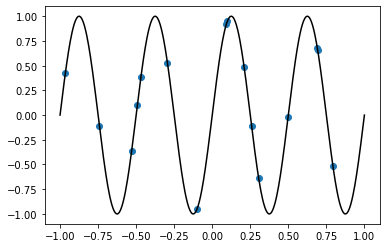

In [7]:
train_input = (np.random.rand(nsample)*2.0-1.0).reshape(-1,1).astype(np.float32)
train_output = func(train_input)

test_input = np.linspace(-1, 1, 512).reshape(-1,1).astype(np.float32)
test_output = func(test_input)

train_data_loader = torch.utils.data.DataLoader(list(zip(train_input,train_output)), batch_size=nsample, shuffle=False)
test_data_loader = torch.utils.data.DataLoader(list(zip(test_input,test_output)), batch_size=512, shuffle=False) 

for x,y in test_data_loader:
    plt.plot(x,y,c='k')
    
for x,y in train_data_loader:
    plt.scatter(x,y)        

# GP

In [8]:
kernel = C(0.2, (1e-3, 1e3)) * RBF(1, (1e-2, 1e3))
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9)

In [9]:
gp.score(train_input,train_output), gp.score(test_input,test_output)

(-0.07630889646194206, -1.2522545222992676e-09)

In [10]:
gp.fit(train_input, train_output)
gp.kernel_

/usr/common/software/pytorch/v1.4.0/lib/python3.7/site-packages/sklearn/gaussian_process/_gpr.py:494: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


3.99**2 * RBF(length_scale=0.25)

In [11]:
gp.score(train_input,train_output), gp.score(test_input,test_output)

(0.9999999999999366, 0.9980204677188241)

In [12]:
gp_predict_mean, gp_predict_std = gp.predict(test_input, return_std=True)
gp_predict_mean = gp_predict_mean.reshape(-1)

/usr/common/software/pytorch/v1.4.0/lib/python3.7/site-packages/sklearn/gaussian_process/_gpr.py:362: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


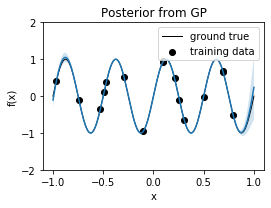

In [13]:
plt.figure(figsize=(4,3))

plt.plot(test_input,test_output,label='ground true',lw=1,c='k')
plt.fill_between(test_input[:,0], 
                 gp_predict_mean + 1.96*gp_predict_std, 
                 gp_predict_mean - 1.96*gp_predict_std, alpha=0.2)
plt.plot(test_input,gp_predict_mean)
plt.scatter(train_input,train_output,c='k',label='training data')

# plt.legend()
plt.title('Posterior from GP')
plt.xlabel('x');
plt.ylabel('f(x)');
plt.ylim(-2,2)
plt.legend(loc = 'upper right')
plt.tight_layout()
plt.savefig('GP.png',dpi=180)

# NNensemble (ReLU)

In [14]:
def test(model,test_data_loader):
    model.eval()
    loss = 0 
    for x, y in test_data_loader:
        x = x.to(device)
        y_pred = model(x)
        loss += torch.nn.MSELoss()(y_pred, y.to(device)).item()
    return loss/len(test_data_loader)

In [15]:
model_outputs = [0]*nModel
model_test_outputs = [0]*nModel
Hist = [0]*nModel

for i in range(nModel):
    model = ptt.FCNN(nodes=nodes, activation=torch.nn.ReLU(inplace=True),dropout_p=0)
    old_best_loss = 10
    for j in range(8):
        mode,hist = ptt.train_supervised(model, 1.0e-2,1000,
                                         train_data_loader,
                                         criterion=torch.nn.MSELoss(),
                                         old_best_loss = old_best_loss,
                                         dispHead = 0, dispTail = 0)

        newloss = test(model,test_data_loader)
        print(j,newloss)

        if newloss < old_best_loss:
            old_best_loss = newloss
            final_model = copy(model)
            final_hist  = copy(hist)

        if newloss < 2e-3:
            break

    model = final_model
    hist = final_hist
    mode,hist = ptt.train_supervised(model,2.0e-4,2000,
                                     train_data_loader,
                                     old_hist = hist,
                                     criterion=torch.nn.MSELoss(),
                                     old_best_loss = newloss,
                                     dispHead = 0, dispTail = 0)
    Hist[i]=hist
    model_outputs[i] = []
    model_test_outputs[i] = []

    model.eval()  
    with torch.no_grad():
        for x,y in train_data_loader:
            surrogate_y = model(x.to(device))
            model_outputs[i] = model_outputs[i] + surrogate_y.cpu().tolist()

        for x,y in test_data_loader:  
            surrogate_y = model(x.to(device))
            model_test_outputs[i] = model_test_outputs[i] + surrogate_y.tolist()

0 0.3333011865615845ain loss = 0.001330
1 0.16101005673408508in loss = 0.000018
2 0.1458710879087448ain loss = 0.000010
3 0.11379168182611465in loss = 0.000009
4 0.12137456238269806in loss = 0.000014
5 0.1159336119890213ain loss = 0.000020
6 0.12377414852380753in loss = 0.000011
7 0.11486272513866425in loss = 0.000026
0 1.0783090591430664ain loss = 0.0002296
1 0.7256149649620056ain loss = 0.000065
2 0.6186249256134033ain loss = 0.000048
3 0.5219283103942871ain loss = 0.000011
4 0.5265306234359741ain loss = 0.000011
5 0.43674856424331665in loss = 0.000030
6 0.4267042279243469ain loss = 0.000023
7 0.3988510072231293ain loss = 0.000023
0 0.28557702898979187in loss = 0.1057324
1 0.1439516246318817ain loss = 0.000842
2 0.10257519036531448in loss = 0.000015
3 0.11646905541419983in loss = 0.000012
4 0.12577667832374573in loss = 0.000012
5 0.12716686725616455in loss = 0.000026
6 0.12704771757125854in loss = 0.000002
7 0.1385262906551361ain loss = 0.000001
0 0.49097740650177train loss = 0.02001

No handles with labels found to put in legend.


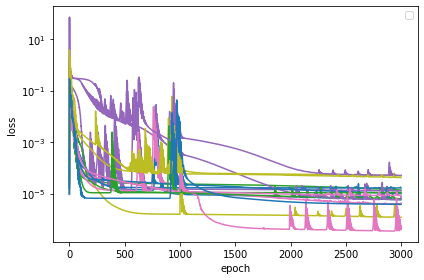

In [16]:
for hist in Hist:
  ptt.plot.history(hist)
plt.legend(loc = 'upper right')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.tight_layout()
plt.savefig('NNensemble_ReLU_hist.png',dpi=180)

In [17]:
model_test_outputs = np.array(model_test_outputs)
model_test_outputs_mean = np.mean(model_test_outputs,axis=0).reshape(-1,1)
model_test_outputs_std  = np.std(model_test_outputs,axis=0).reshape(-1,1)

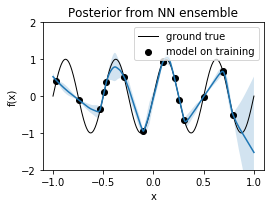

In [18]:
plt.figure(figsize=(4,3))

plt.plot(test_input,test_output,label='ground true',lw=1,c='k')
plt.fill_between(test_input[:,0], 
                 model_test_outputs_mean[:,0] + 1.96*model_test_outputs_std[:,0], 
                 model_test_outputs_mean[:,0] - 1.96*model_test_outputs_std[:,0], alpha=0.2)
plt.plot(test_input,model_test_outputs_mean)
plt.scatter(train_input,train_output,c='k',label='model on training')
plt.xlabel('x');
plt.ylabel('f(x)');
plt.ylim(-2,2)
plt.legend(loc = 'upper right')
plt.title('Posterior from NN ensemble')
plt.tight_layout()
plt.savefig('NNensemble_ReLU.png',dpi=180)

# NNensemble (CELU)

In [19]:
odel_outputs = [0]*nModel
model_test_outputs = [0]*nModel
Hist = [0]*nModel

for i in range(nModel):
    model = ptt.FCNN(nodes=nodes, activation=torch.nn.CELU(inplace=True),dropout_p=0)
    old_best_loss = 10
    for j in range(8):
        mode,hist = ptt.train_supervised(model, 1.0e-2, 1000,
                                         train_data_loader,
                                         criterion=torch.nn.MSELoss(),
                                         old_best_loss = old_best_loss,
                                         dispHead = 0, dispTail = 0)

        newloss = test(model,test_data_loader)
        print(j,newloss)

        if newloss < old_best_loss:
            old_best_loss = newloss
            final_model = copy(model)
            final_hist  = copy(hist)

        if newloss < 2e-3:
            break

    model = final_model
    hist = final_hist
    mode,hist = ptt.train_supervised(model,2.0e-4,2000,
                                     train_data_loader,
                                     old_hist = hist,
                                     criterion=torch.nn.MSELoss(),
                                     old_best_loss = newloss,
                                     dispHead = 0, dispTail = 0)
    Hist[i]=hist
    model_outputs[i] = []
    model_test_outputs[i] = []

    model.eval()  
    with torch.no_grad():
        for x,y in train_data_loader:
            surrogate_y = model(x.to(device))
            model_outputs[i] = model_outputs[i] + surrogate_y.cpu().tolist()

        for x,y in test_data_loader:  
            surrogate_y = model(x.to(device))
            model_test_outputs[i] = model_test_outputs[i] + surrogate_y.tolist()

0 0.39443114399909973in loss = 0.011761
1 0.6595524549484253ain loss = 0.000028
2 0.29517483711242676in loss = 0.000008
3 0.31381866335868835in loss = 0.000004
4 0.2806144654750824ain loss = 0.000001
5 0.29183173179626465in loss = 0.000002
6 0.2880183756351471ain loss = 0.000023
7 0.29448723793029785in loss = 0.000005
0 0.40518978238105774in loss = 0.0051700
1 0.4731237292289734ain loss = 0.001255
2 0.3009496033191681ain loss = 0.001282
3 0.357366681098938rain loss = 0.000547
4 0.29700055718421936in loss = 0.006760
5 0.29176318645477295in loss = 0.000843
6 0.2631932199001312ain loss = 0.000302
7 0.3005184233188629ain loss = 0.000910
0 0.5561163425445557ain loss = 0.2091638
1 0.408463716506958rain loss = 0.004858
2 0.2446671724319458ain loss = 0.000680
3 0.2789584696292877ain loss = 0.000072
4 0.28017792105674744in loss = 0.000067
5 0.2689211666584015ain loss = 0.000222
6 0.27772194147109985in loss = 0.000067
7 0.3389921188354492ain loss = 0.000059
0 0.46212238073349train loss = 0.05432

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



No handles with labels found to put in legend.


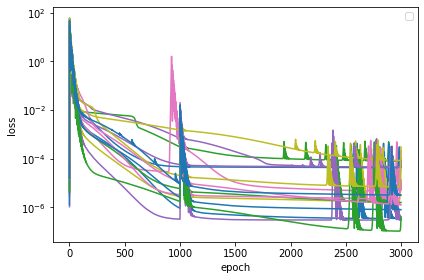

In [20]:
for hist in Hist:
  ptt.plot.history(hist)
plt.legend(loc = 'upper right')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.tight_layout()
plt.savefig('NNensemble_CELU_hist.png',dpi=180)

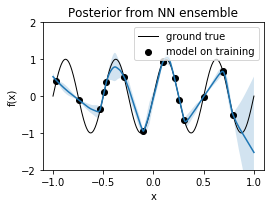

In [21]:
plt.figure(figsize=(4,3))

plt.plot(test_input,test_output,label='ground true',lw=1,c='k')
plt.fill_between(test_input[:,0], 
                 model_test_outputs_mean[:,0] + 1.96*model_test_outputs_std[:,0], 
                 model_test_outputs_mean[:,0] - 1.96*model_test_outputs_std[:,0], alpha=0.2)
plt.plot(test_input,model_test_outputs_mean)
plt.scatter(train_input,train_output,c='k',label='model on training')
plt.xlabel('x');
plt.ylabel('f(x)');
plt.ylim(-2,2)
plt.legend(loc = 'upper right')
plt.title('Posterior from NN ensemble')
plt.tight_layout()
plt.savefig('NNensemble_CELU.png',dpi=180)